# Audio representations

In [44]:
import os
import math
import IPython
import torch
import torchaudio
from audiomentations import Compose, AddGaussianSNR, AddGaussianNoise, AddImpulseResponse, AddShortNoises, AddBackgroundNoise
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
torchaudio.USE_SOUNDFILE_LEGACY_INTERFACE = False
#torchaudio.set_audio_backend("sox_io")

DATA_PATH = '../data/'
plt.rcParams['figure.dpi'] = 160

if not os.path.exists(os.path.join(DATA_PATH, 'LibriSpeech')):
    torchaudio.datasets.LIBRISPEECH(DATA_PATH, url='test-clean', download=True)

In [4]:
test_file_path = os.path.join(DATA_PATH, "LibriSpeech/test-clean/121/127105/121-127105-0036.flac")
signal, sample_rate = torchaudio.load(test_file_path)
#print(vars(torchaudio.info(test_file_path)))

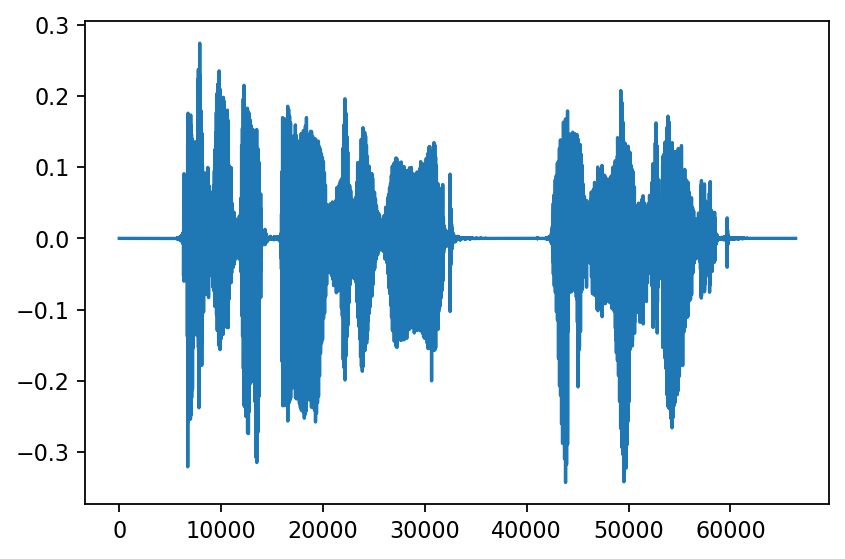

In [5]:
plt.plot(signal.t().detach())
IPython.display.Audio(test_file_path)

## Spectogram

torch.Size([1, 201, 333])


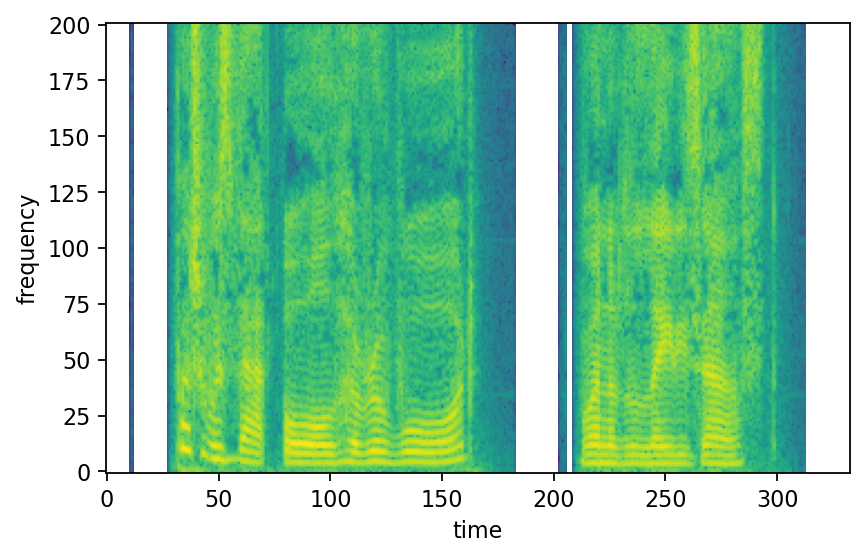

In [7]:
spectro = torchaudio.transforms.Spectrogram()(signal)
print(spectro.shape)

plt.imshow(spectro.log2()[0,:,:], cmap='viridis')
plt.ylabel('frequency')
plt.xlabel('time')
plt.gca().invert_yaxis()
#plt.savefig('spectro.pdf') 

## Mel-spectrogram

torch.Size([1, 128, 333])


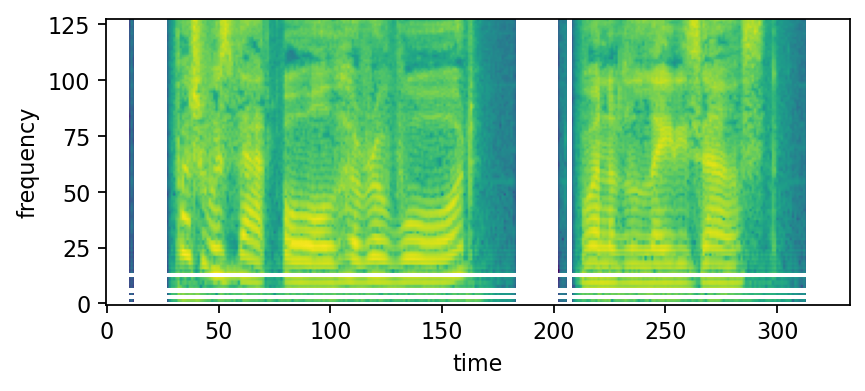

In [26]:
n_mels = 128
n_fft = 400
mel_spectro = torchaudio.transforms.MelSpectrogram(n_mels=n_mels, n_fft=n_fft)(signal)
print(mel_spectro.shape)

plt.imshow(mel_spectro.log2()[0,:,:], cmap='viridis')
plt.ylabel('frequency')
plt.xlabel('time')
plt.gca().invert_yaxis()
#plt.savefig('melspectro.pdf') 

## MelSpectrogram with pre-emphasis and instance normalization

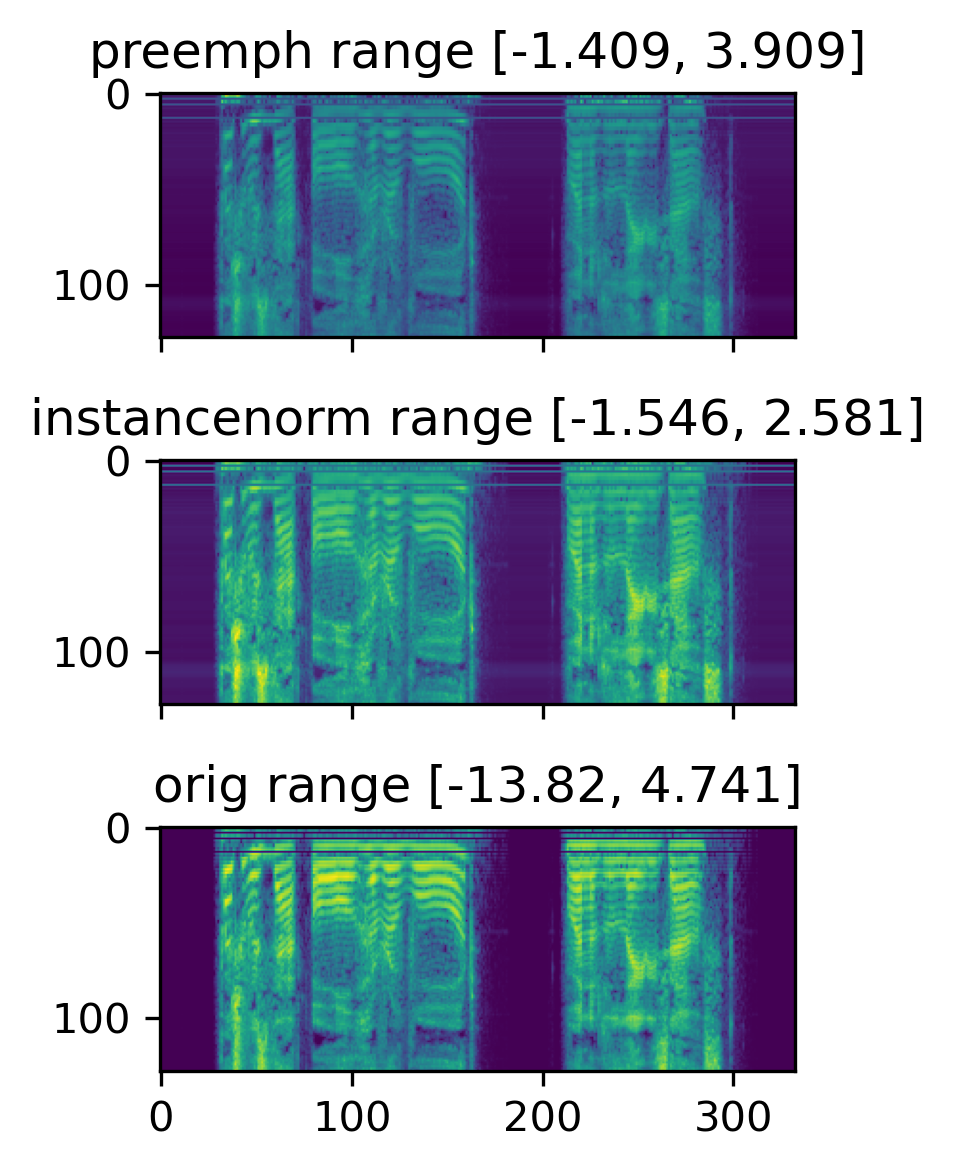

In [102]:
import torch.nn.functional as F
class PreEmphasis(torch.nn.Module):  # pylint: disable=abstract-method
    def __init__(self, coef: float = 0.97):
        super().__init__()
        self.coef = coef
        # make kernel
        # In pytorch, the convolution operation uses cross-correlation. So, filter is flipped.
        self.register_buffer(
            'flipped_filter', torch.FloatTensor([-self.coef, 1.]).unsqueeze(0).unsqueeze(0)
        )

    def forward(self, input: torch.Tensor) -> torch.Tensor:
        assert len(input.size()) == 2, 'The number of dimensions of input tensor must be 2!'
        # reflect padding to match lengths of in/out
        input = input.unsqueeze(1)
        input = F.pad(input, (1, 0), 'reflect')  # type: ignore
        return F.conv1d(input, self.flipped_filter).squeeze(1)  # type: ignore

x = signal
x = PreEmphasis()(x)
x = torchaudio.transforms.MelSpectrogram(n_mels=n_mels, n_fft=n_fft)(x)
x = x+1e-6
x = x.log()
x = torch.nn.InstanceNorm1d(n_mels)(x)

y = signal
y = torchaudio.transforms.MelSpectrogram(n_mels=n_mels, n_fft=n_fft)(y)
y = y+1e-6
y = y.log()
y = torch.nn.InstanceNorm1d(n_mels)(y)

z = signal
z = torchaudio.transforms.MelSpectrogram(n_mels=n_mels, n_fft=n_fft)(z)
z = z+1e-6
z = z.log()

fig, axes = plt.subplots(nrows=3, ncols=1, sharex=True, sharey=True, dpi=300)

axes[0].set_title('preemph range [{:.4}, {:.4}]'.format(torch.min(x), torch.max(x)))
axes[0].imshow(x[0,:,:], cmap='viridis')

axes[1].set_title('instancenorm range [{:.4}, {:.4}]'.format(torch.min(y), torch.max(y)))
axes[1].imshow(y[0,:,:], cmap='viridis')

axes[2].set_title('orig range [{:.4}, {:.4}]'.format(torch.min(z), torch.max(z)))
axes[2].imshow(z[0,:,:], cmap='viridis')

fig.tight_layout()

### MelSpectrogram with SpecAugment (without time warping)
https://arxiv.org/abs/1904.08779
https://discuss.pytorch.org/t/does-sparse-image-warp-from-tf-exist-in-pytorch/43514

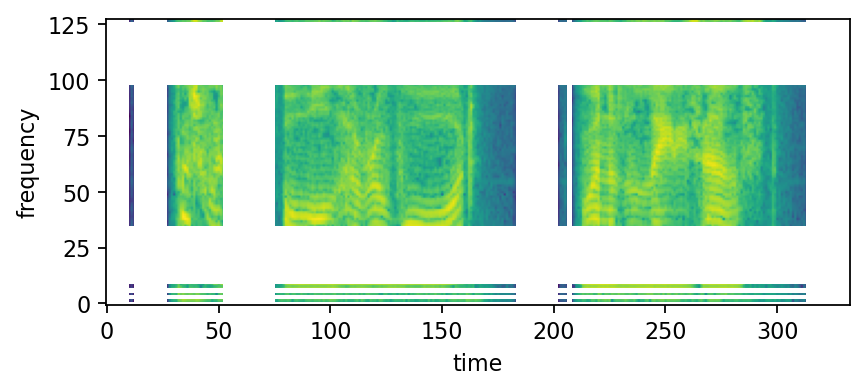

In [9]:
F=0.25
T=0.15

mel_spectro = torch.nn.Sequential(
    torchaudio.transforms.MelSpectrogram(n_mels=n_mels, n_fft=n_fft),
    torchaudio.transforms.FrequencyMasking(freq_mask_param=int(F * n_mels)),
    torchaudio.transforms.FrequencyMasking(freq_mask_param=int(F * n_mels)),
    torchaudio.transforms.TimeMasking(time_mask_param=int(T * (n_fft // 2 + 1))),
    torchaudio.transforms.TimeMasking(time_mask_param=int(T * (n_fft // 2 + 1)))
)(signal)

plt.imshow(mel_spectro.log2()[0,:,:], cmap='viridis')
plt.ylabel('frequency')
plt.xlabel('time')
plt.gca().invert_yaxis()
#plt.savefig('melspectro-aug.pdf') 

## Mel-frequency cepstral coefficients

torch.Size([1, 128, 333])


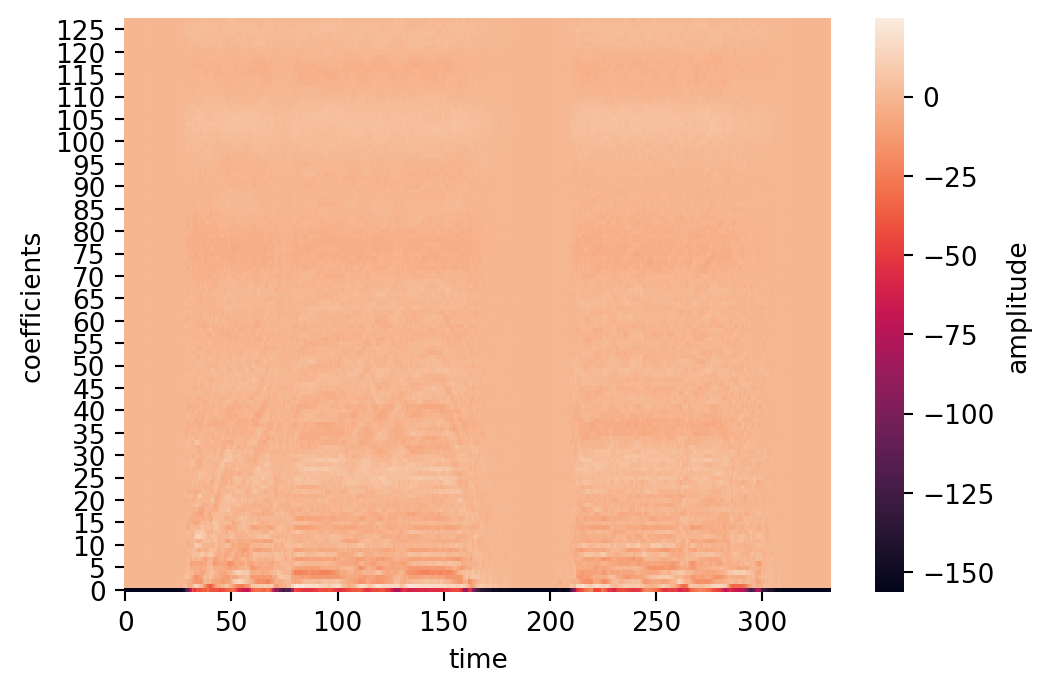

In [22]:
mfcc = torchaudio.transforms.MFCC(sample_rate=sample_rate, n_mfcc=n_mels, log_mels=True)(signal)
print(mfcc.shape)

plt.figure(dpi=190)
ax = sns.heatmap(mfcc[0,:,:], xticklabels=50, yticklabels=5, cbar_kws={'label': 'amplitude'})
ax.set(xlabel='time', ylabel='coefficients')
plt.gca().invert_yaxis()
plt.show()
#ax.get_figure().savefig('mfcc.pdf') 

# Comparisons to signal augmented with gaussian noise

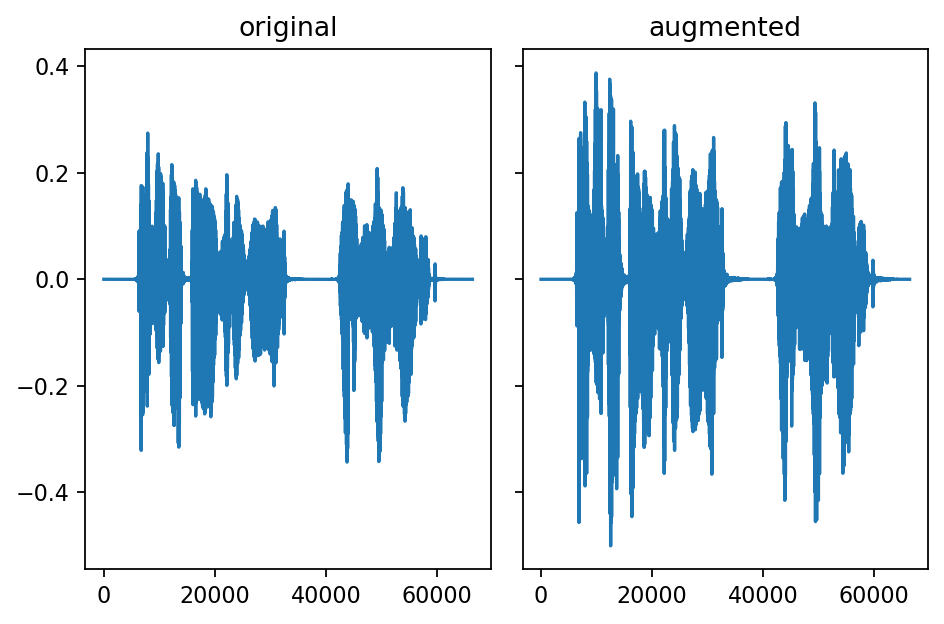

In [100]:
# Augment with gaussian noise
augment = Compose([
    #AddGaussianSNR(min_SNR=0.5, max_SNR=0.5, p=1.0),
    #AddShortNoises(os.path.join(DATA_PATH, 'RIRS_NOISES', 'pointsource_noises'), max_snr_in_db=80, p=1.0)
    #AddBackgroundNoise(os.path.join(DATA_PATH, 'RIRS_NOISES', 'pointsource_noises'), p=1.0)
    AddImpulseResponse(os.path.join(DATA_PATH, 'RIRS_NOISES', 'simulated_rirs'), leave_length_unchanged=True, p=1.0)
])
augmented_np = augment(samples=signal.t().numpy().flatten(), sample_rate=sample_rate)

fig, axes = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True)

axes[0].set_title('original')
axes[0].plot(signal.t().detach())

axes[1].set_title('augmented')
axes[1].plot(augmented_np)

fig.tight_layout()

In [77]:
# Augmented signal
IPython.display.Audio(augmented_np, rate=sample_rate)

In [25]:
# Original signal
IPython.display.Audio(signal, rate=sample_rate)

## Spectogram

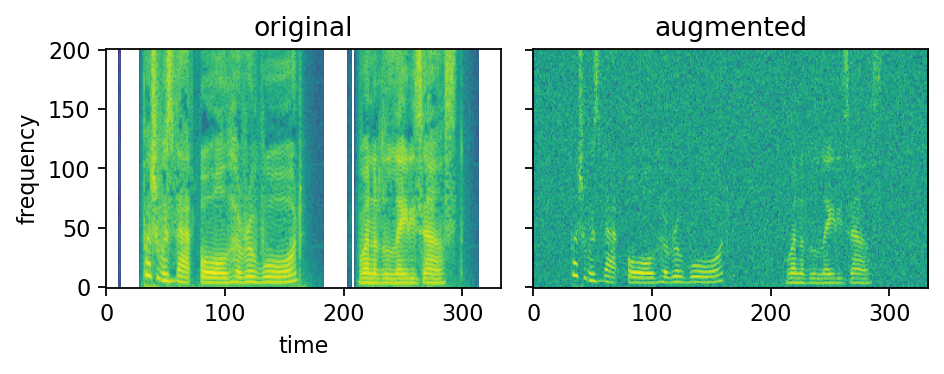

In [204]:
augmented = torch.from_numpy(augmented_np).view(1,-1)

fig, axes = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True)

axes[0].set(xlabel='time', ylabel='frequency')
axes[0].set_title('original')
axes[0].imshow(spectro.log2()[0,:,:], cmap='viridis')
axes[0].invert_yaxis()

spectro_aug = torchaudio.transforms.Spectrogram()(augmented)
axes[1].set_title('augmented')
axes[1].imshow(spectro_aug.log2()[0,:,:], cmap='viridis')
axes[1].invert_yaxis()
fig.tight_layout()

## Mel-spectogram

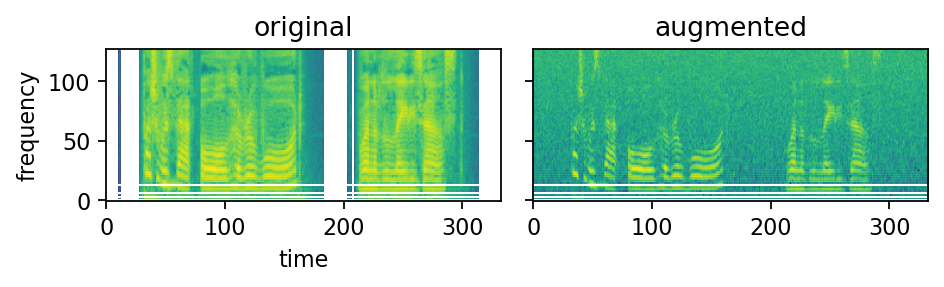

In [205]:
mel_spectro_aug = torchaudio.transforms.MelSpectrogram()(augmented)

fig, axes = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True)

axes[0].set(xlabel='time', ylabel='frequency')
axes[0].set_title('original')
axes[0].imshow(mel_spectro.log2()[0,:,:], cmap='viridis')
axes[0].invert_yaxis()

axes[1].set_title('augmented')
axes[1].imshow(mel_spectro_aug.log2()[0,:,:], cmap='viridis')
axes[1].invert_yaxis()
fig.tight_layout()

## Mel-frequency cepstral coefficients

<Figure size 1140x760 with 0 Axes>

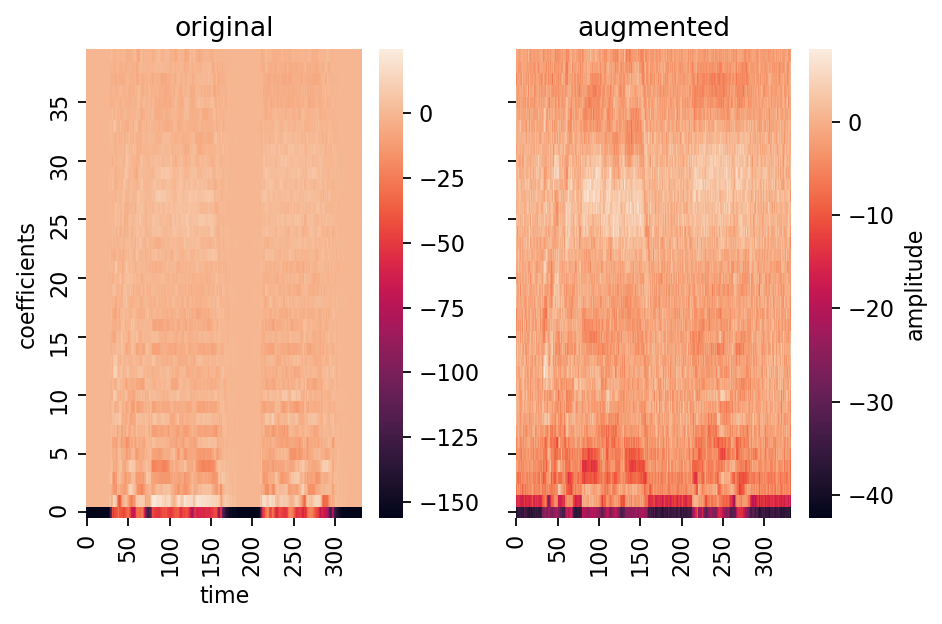

In [206]:
mfcc_aug = torchaudio.transforms.MFCC(sample_rate=sample_rate, log_mels=True)(augmented)

plt.figure(dpi=190)
fig, axes = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True)

sns.heatmap(mfcc[0,:,:], ax=axes[0], xticklabels=50, yticklabels=5)
axes[0].set(xlabel='time', ylabel='coefficients')
axes[0].set_title('original')
axes[0].invert_yaxis()

axes[1].set_title('augmented')
sns.heatmap(mfcc_aug[0,:,:], ax=axes[1], xticklabels=50, yticklabels=5, cbar_kws={'label': 'amplitude'})
axes[1].invert_yaxis()
fig.tight_layout()
plt.show()